In [57]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sgp4.ext import invjday
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday
from datetime import datetime, timedelta

In [58]:
username = 'asas4539@hanyang.ac.kr'
password = 'onsaemiro1729!!'

In [59]:
def get_tle():
    # Space-Track API의 URL
    url = "https://www.space-track.org/ajaxauth/login"

    # 요청에 필요한 인증 정보
    payload = {"identity": username, "password": password}

    # Session 객체 생성
    session = requests.Session()

    # 로그인 요청
    response = session.post(url, data=payload)

    if response.status_code != 200:
        print("로그인에 실패했습니다.")
        return None

    # TLE 요청
    response = session.get(
        f"https://www.space-track.org/basicspacedata/query/class/tle/NORAD_CAT_ID/25544/EPOCH/2023-01-01--2024-07-14/orderby/EPOCH%20asc/format/3le/emptyresult/show"
    )  #

    return response

In [60]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [61]:
response = get_tle()
tle_datas = response.text.split('\r\n')

tle_first_lst = []
tle_second_lst = []

for i in range(0, len(tle_datas) - 2, 3):
    tle_first_lst.append(tle_datas[i + 1])
    tle_second_lst.append(tle_datas[i + 2])

tle_df = pd.DataFrame({'first_line': tle_first_lst, 'second_line': tle_second_lst})
tle_df.drop_duplicates(keep='first', inplace=True)
tle_df.reset_index(inplace=True, drop=True)

In [62]:
change_times = []
for i in range(len(tle_df)):
    tle_1, tle_2 = tle_df['first_line'].iloc[i], tle_df['first_line'].iloc[i]
    satellite = Satrec.twoline2rv(tle_1, tle_2)
    jdsatepoch = satellite.jdsatepoch
    jdsatepochfrac = satellite.jdsatepochF
    epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
    change_times.append(epochdatetime)

In [63]:
change_df = pd.DataFrame(change_times)
change_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
change_df['first_line'] = tle_df['first_line']
change_df['second_line'] = tle_df['second_line']
change_df['time'] = pd.to_datetime(change_df[['year', 'month', 'day', 'hour', 'minute', 'second']])
change_df['time'].drop_duplicates(keep='first', inplace=True)

In [68]:
epoch = datetime(2023, 1, 1, 0, 0, 0)
all_info = []

earth_radius = 6378.137
rad2deg = 180.0 / np.pi

while epoch < datetime(2024, 7, 14, 0, 0, 0):
    # print(epoch)
    year = epoch.year
    month = epoch.month
    date = epoch.day
    hour = epoch.hour
    minute = epoch.minute

    now_time = f'{year}-{month}-{date} {hour}:{minute}:00'
    temp = change_df[change_df['time'] <= pd.to_datetime(now_time)].copy()
    tle1, tle2 = temp.iloc[-1]['first_line'], temp.iloc[-1]['second_line']

    satellite = Satrec.twoline2rv(tle1, tle2)
    jd, fr = jday(year, month, date, hour, minute, 0)
    e, position, velocity = satellite.sgp4(jd, fr)

    all_info.append([
        len(temp), tle1, tle2,
        epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute,
        *position, *velocity,
        (sum(p ** 2 for p in position) ** 0.5) - earth_radius,
        (sum(v ** 2 for v in velocity) ** 0.5),
        satellite.alta * earth_radius, satellite.altp * earth_radius,
        satellite.inclo * rad2deg, satellite.ecco, satellite.nodeo
    ])

    epoch += timedelta(minutes=1)

IndexError: single positional indexer is out-of-bounds

In [40]:
info_df = pd.DataFrame(all_info)
info_df.columns = ['change', 'tle1', 'tle2', 'year', 'month', 'day', 'hour', 'minute',
                   'x', 'y', 'z', 'vx', 'vy', 'vz',
                   'altitude', 'velocity', 'apogee', 'perigee', 'inclination', 'eccentricity', 'raan']
info_df['change'] = (info_df['change'].diff().fillna(1) >= 1) * 1

In [41]:
info_wo_tle_df = info_df.drop(['tle1', 'tle2'], axis=1).copy()
info_wo_tle_df.to_csv('File/info_wo_tle_df_25544.csv')
info_wo_tle_df = pd.read_csv('File/info_wo_tle_df_25544.csv', index_col=0)

# 그래프

In [42]:
name = 'velocity'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', name]]

In [43]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_1 = df_1.resample('h').mean()

In [44]:
if name == 'altitude' or 'velocity':
    df_2 = df_1.rolling(window=120).mean().dropna()
# df_2 = df_1

In [45]:
window = 500
ol_idxs = []
for i in range(window, 5400 - window, 1):
    window_diff = df_2[i - window: i]
    z_norm = ((window_diff - window_diff.mean()) / window_diff.std())
    final_val = float(z_norm.values[-1])

    if np.abs(final_val) > 3:
        ol_idxs.append(i)

In [46]:
df_3=df_2.diff().dropna()

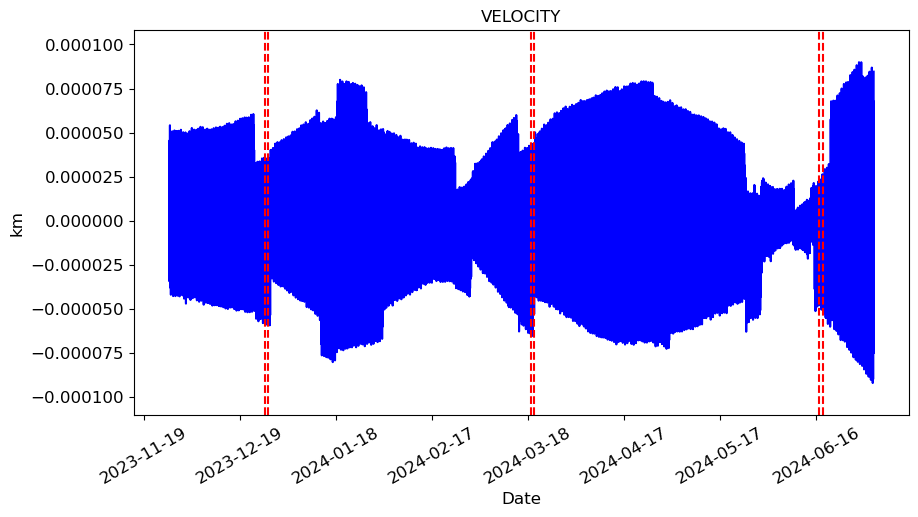

In [47]:
draw_graph(df_3, name.upper(), 'km',
           pd.DataFrame(df_2.iloc[ol_idxs].index.date).drop_duplicates().values.tolist(), "blue")

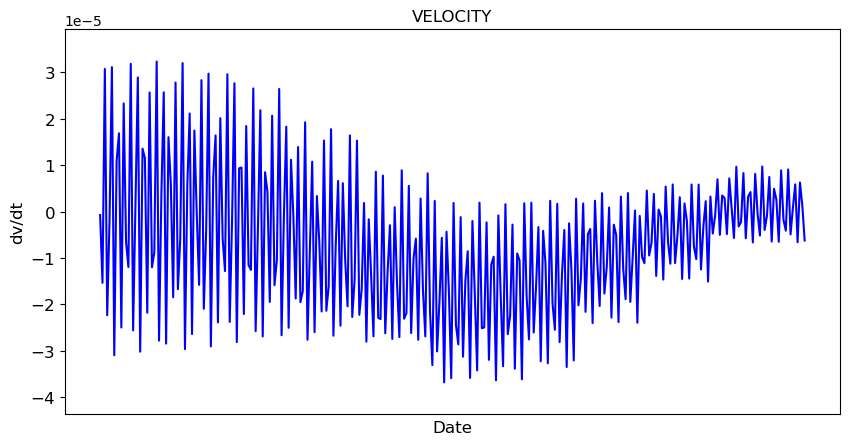

In [33]:
plt.figure(figsize=(10, 5))

plt.plot(df_3.iloc[2000:2300].index, df_3.iloc[2000:2300].values, color='Blue')
# plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params(name.upper(), 'dv/dt')
ylim_min, ylim_max = calculate_ylim(list(df_3.iloc[2000:2300].values))
plt.ylim(ylim_min, ylim_max)
plt.show()

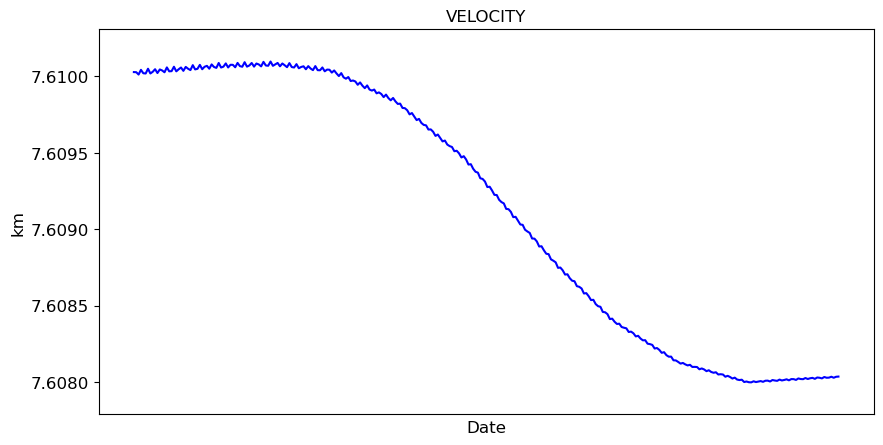

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.iloc[2000:2300].index, df_2.iloc[2000:2300].values, color='Blue')
# plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params(name.upper(), 'km')
ylim_min, ylim_max = calculate_ylim(list(df_2.iloc[2000:2300].values))
plt.ylim(ylim_min, ylim_max)
plt.show()

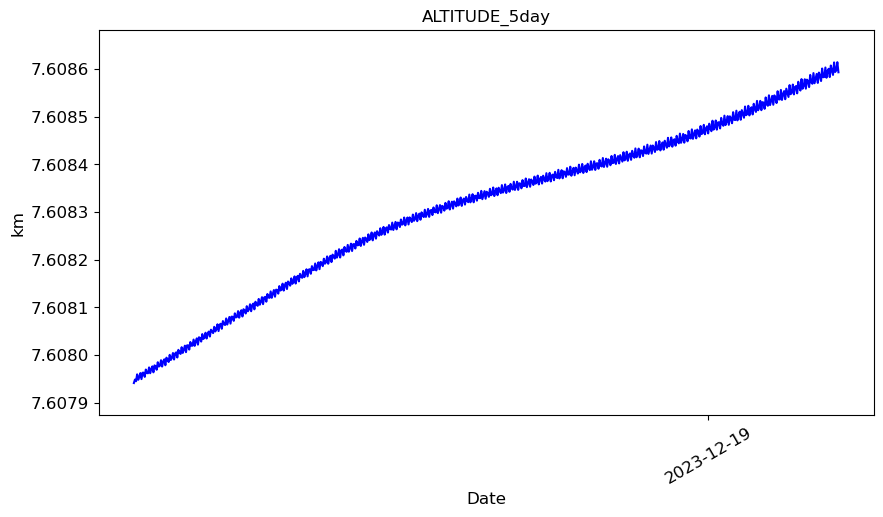

In [34]:
plt.figure(figsize=(10, 5))

plt.plot(df_2.iloc[:650,:].index, df_2.iloc[:650,:].values, color='Blue')
# plt.scatter(df_2.iloc[ol_idxs].index, df_2.iloc[ol_idxs], c='tab:red', s=10)

set_plot_params('ALTITUDE_5day', 'km')
ylim_min, ylim_max = calculate_ylim(list(df_2.iloc[:650,:].values))
plt.ylim(ylim_min, ylim_max)
plt.show()